In [1]:
using AlgebraicPetri
using Catlab.CategoricalAlgebra
using DifferentialEquations, Plots

include("ModelStratify.jl");

## Import Epidemiology Model
This begins by importing a JSON serialized Petri net with rates and initial populations defined. For this example, we will import the SEIIARRD model.

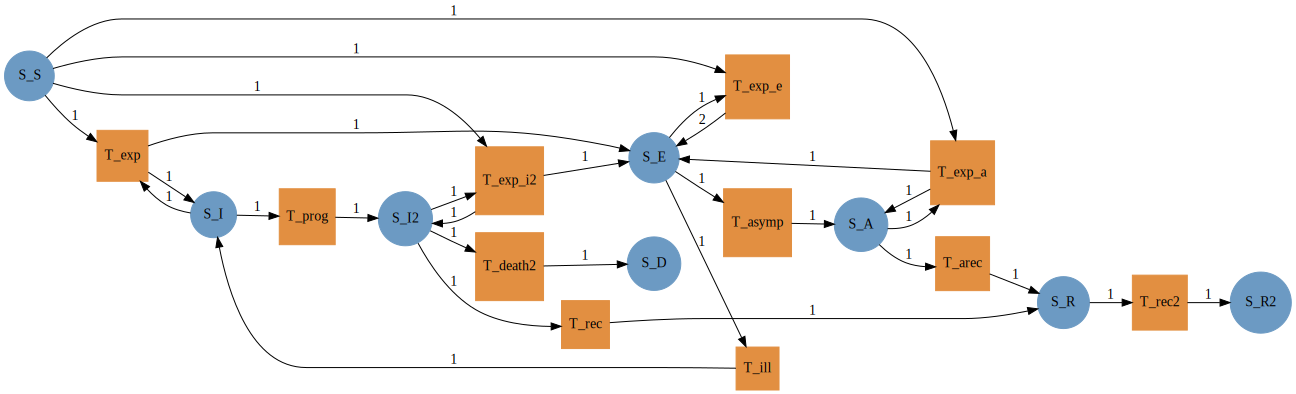

In [2]:
# Read in json string
model_json = open(f->read(f, String), "models/seiiarrd_rates.json");
# Parse json to object
model = ModelStratify.deserialize(model_json, LabelledReactionNet{Number,Number});
# Graph initial model
AlgebraicPetri.Graph(model)

## Import the connection graph
The connection graph will define how the model is stratified. Each vertex in the graph corresponds to a population, and each directed edge corresponds to an interaction transition.

The scale factors on the vertices are the amount the initial population is scaled for that population and the amount the transition rates are scaled. The scale factor on the edges is the amount the interaction rates are scaled for that edge.

For this example, we have 3 populations, where the center interacts with both, and the edge populations only interact with the center population.

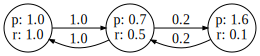

In [3]:
# Read in json string
conn_json = open(f->read(f, String), "connection_graphs/scale_graph.json");
# Parse json to object
conn_graph = ModelStratify.deserialize(conn_json, ModelStratify.ScaleGraph{Number});
ModelStratify.show_graph(conn_graph)

## Perform Demographic Stratification

Demographic stratification interprets the interactions between different populations as cross-infection terms. A directed edge from population A to population B means that persons in population A can infect persons in population B.

When we define the demographic stratification, we need to include the rate at which different exposing states from the source population expose the susceptible state in the target population.

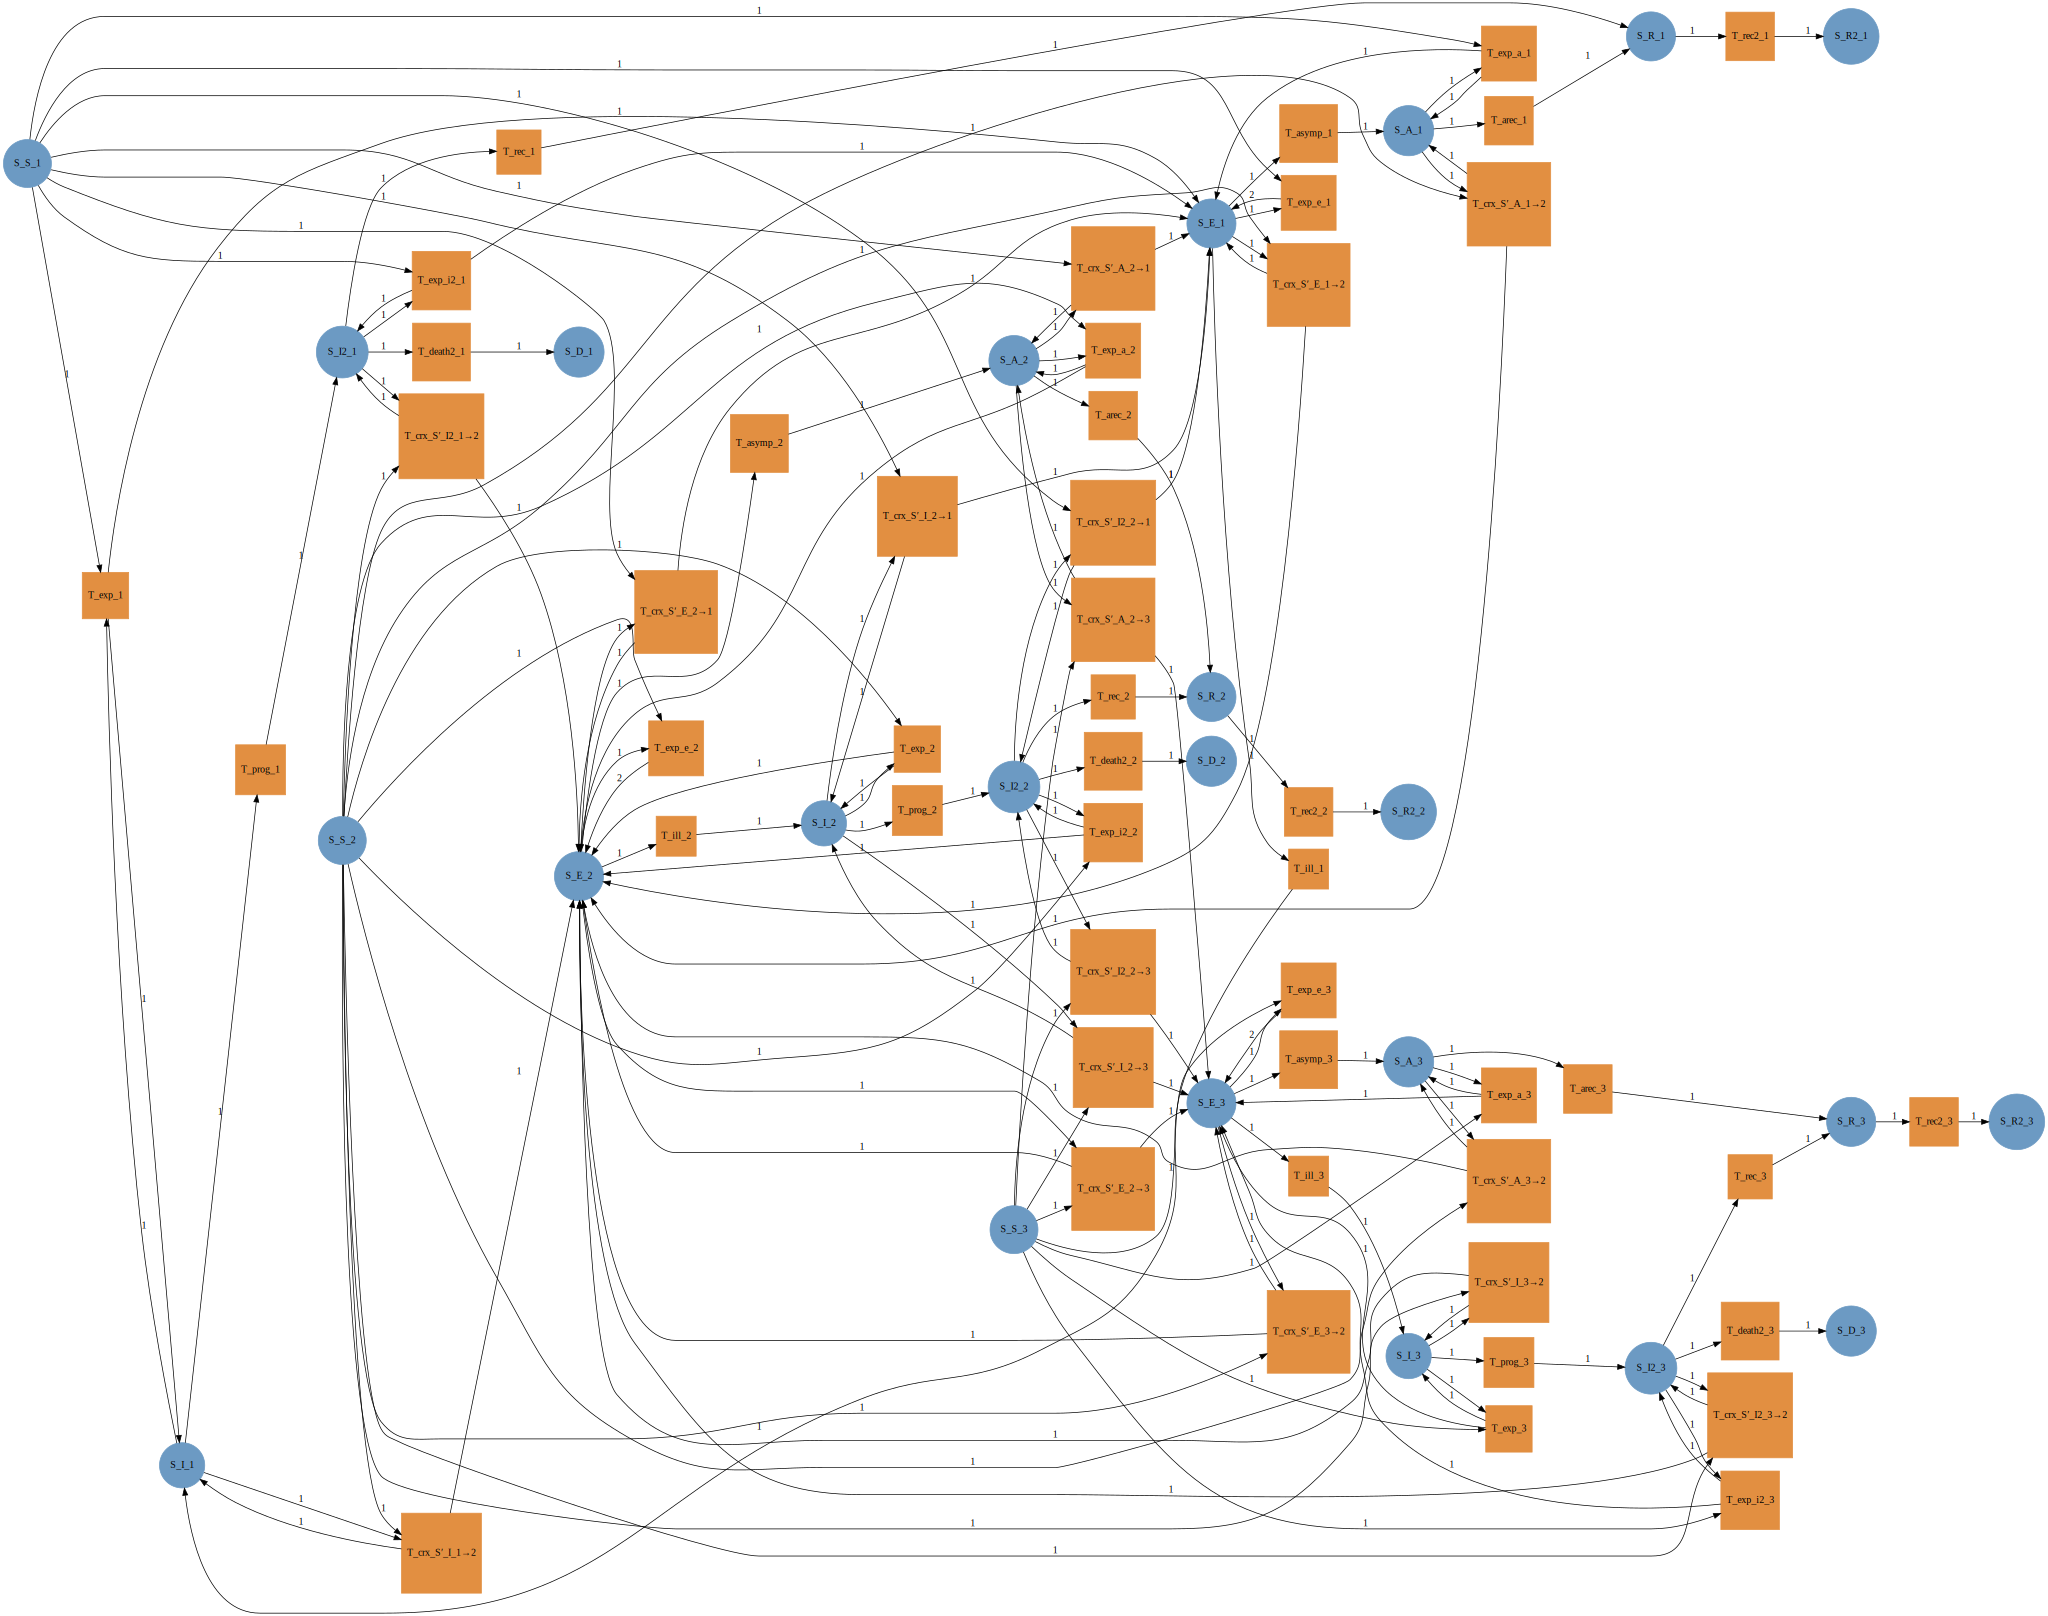

In [4]:
demographic_model = ModelStratify.dem_strat(model, conn_graph, :S, :E, [:E=>0.5,:A=>0.8,:I=>0.1,:I2=>0.1], scaled_transitions=[:exp_i2, :exp, :exp_e, :exp_a]);
# Save svg and json files of model
ModelStratify.save_model(demographic_model, "demographic_model");
# Display graph of model
AlgebraicPetri.Graph(demographic_model)

## Perform Spatial Stratification

Spatial stratification interprets the interactions between different populations as travel of persons between cities. A directed edge from population A to population B means that persons in population A can travel and become persons in population B.

When we define the diffusion stratification, we need to include the rate at which different states diffuse between populations.

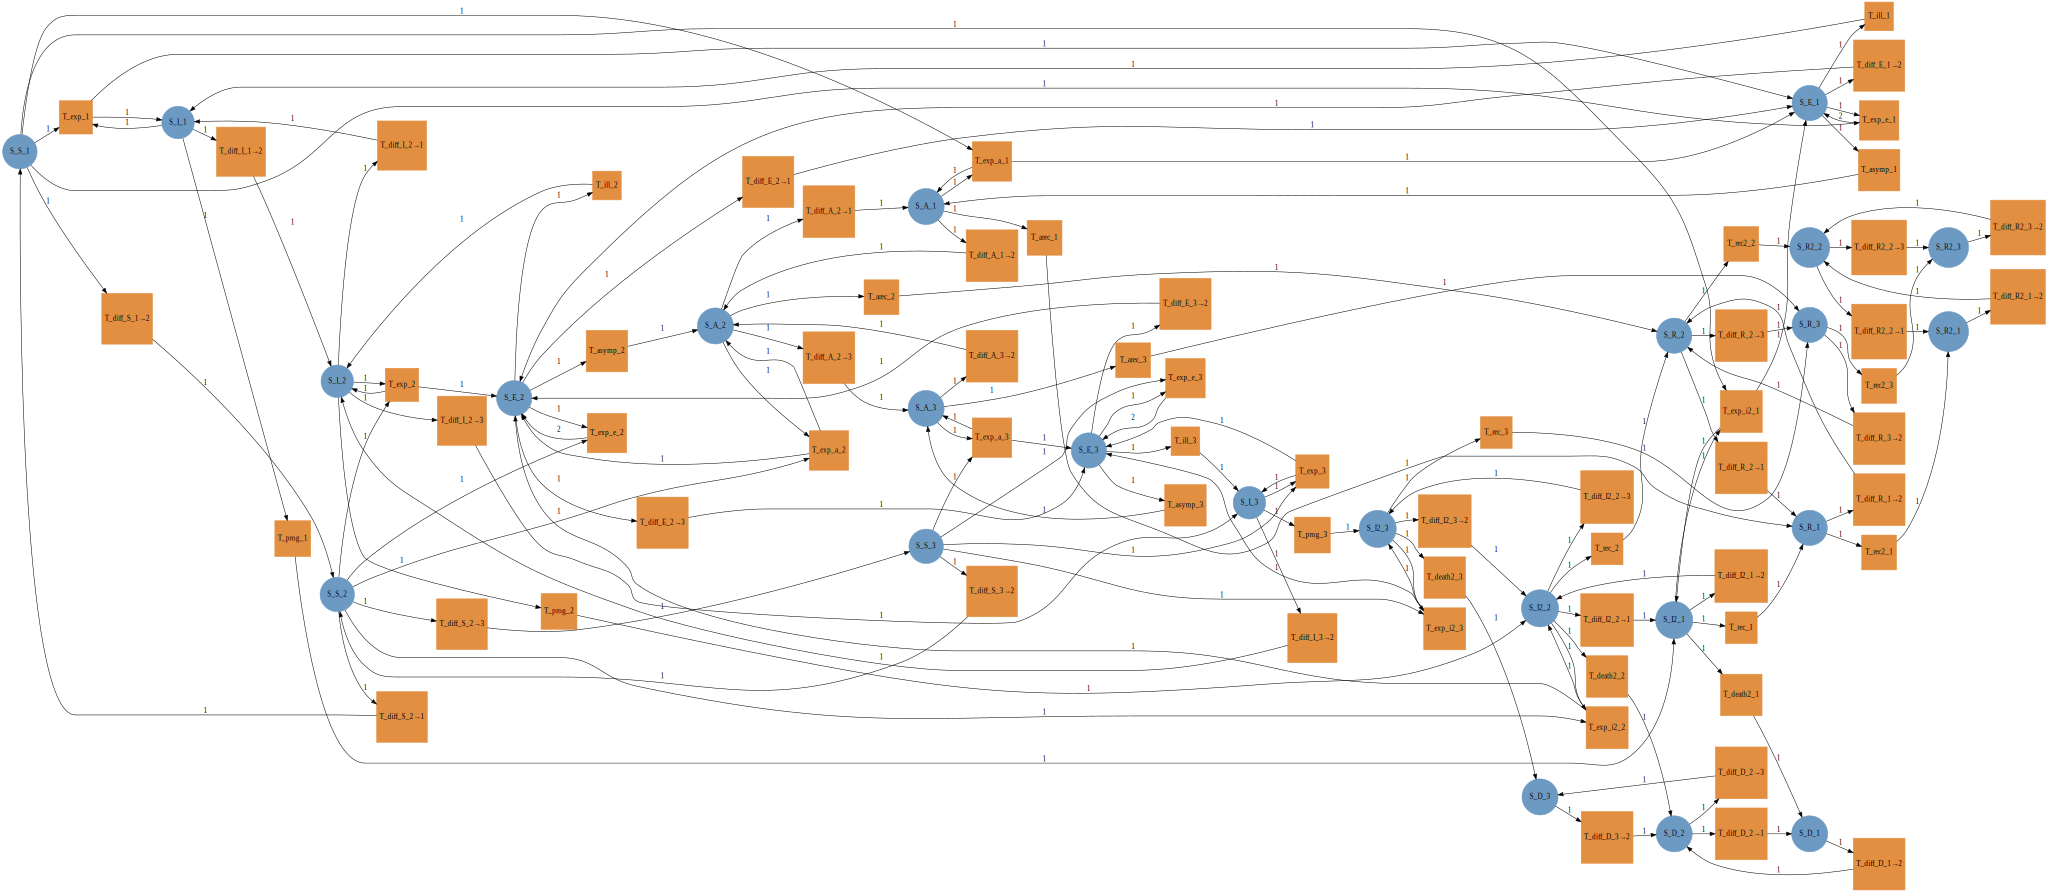

In [5]:
spatial_model = ModelStratify.diff_strat(model, conn_graph, [:S=>0.3e-4, :I=>0.01e-6, :E=>0.2e-6, 
                                                             :I2=>0.01e-6, :A=>0.3e-5, :R=>0.3e-4,
                                                             :D=>0, :R2=>0.3e-4], 
                                                scaled_transitions=[:exp_i2, :exp, :exp_e, :exp_a]);
# Save svg and json files of model
ModelStratify.save_model(spatial_model, "spatial_model");
# Display graph of model
AlgebraicPetri.Graph(spatial_model)

## Simulate the generated model

Since we have initial populations and rates between populations, we are able to simulate the model. In this example, we set a single infected person in the first (leftmost) city. We are able to see how the infection travels between the three cities and causes three local infection peaks.

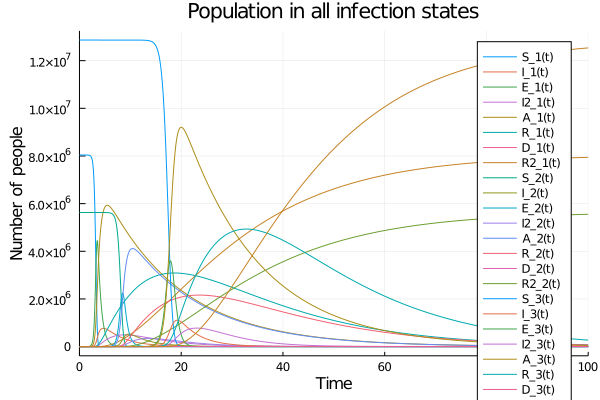

In [6]:
tspan = (0.0,100);
u0 = concentrations(spatial_model)
u0[:I_1] = 1
prob = ODEProblem(vectorfield(spatial_model),u0,tspan,rates(spatial_model));
sol = solve(prob,Tsit5());
plot(sol, xlabel="Time", ylabel="Number of people", title="Population in all infection states")

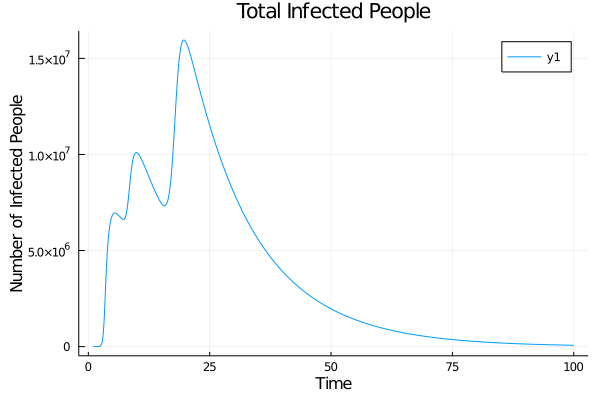

In [7]:
infected_res = [sol(t)[:I_1]+sol(t)[:I_2]+sol(t)[:I_3]+
                sol(t)[:I2_1]+sol(t)[:I2_2]+sol(t)[:I2_3]+
                sol(t)[:A_1]+sol(t)[:A_2]+sol(t)[:A_3] for t in 1:0.1:100]

plot(1:0.1:100,infected_res, xlabel="Time", ylabel="Number of Infected People", title="Total Infected People")

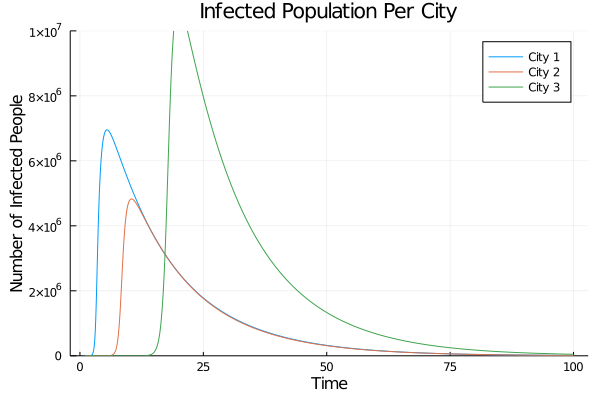

In [8]:
infected1_res = [sol(t)[:I_1]+sol(t)[:I2_1]+sol(t)[:A_1] for t in 1:0.1:100]
infected2_res = [sol(t)[:I_2]+sol(t)[:I2_2]+sol(t)[:A_2] for t in 1:0.1:100]
infected3_res = [sol(t)[:I_3]+sol(t)[:I2_3]+sol(t)[:A_3] for t in 1:0.1:100]
plot(1:0.1:100,[infected1_res, infected2_res, infected3_res], xlabel="Time", ylabel="Number of Infected People", ylim=(0,10000000), title="Infected Population Per City", labels=["City 1" "City 2" "City 3"])